# Soc25: AI Perf (Commits -> Benchmarks)

---

## Table of Contents

| Section Number | Section Title                     | Description                                          |
|----------------|---------------------------------|----------------------------------------------------|
| 1              | [Data Collection](#markdown-header-data-collection)                 | Fetching and aggregating commit messages from GitHub repositories. |
| 2              | [Data Processing & Labeling](#data-processing--labeling)     | Cleaning, encoding labels, and splitting data for training and evaluation. |
| 3              | [Model Architecture](#model-architecture)             | Defining the DistilBERT-based classifier network.  |
| 4              | [Model Training and Evaluation](#markdown-header-model-training-and-evaluation)     | Iterative training, loss calculation, validation, and saving the best model. |
| 5              | [Inference & Testing](#inference--testing)             | Loading the trained model and running predictions on new commit messages. |

---

## Data Collection <a class="anchor" id="data-collection"></a>

*Fetching and aggregating commit messages from GitHub repository.*
Reference: https://github.com/adoptium/aqa-tests

In [41]:
!pip install PyGithub
!pip install transformers==4.38.0
!pip install accelerate==0.27.2
!pip install evaluate


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [42]:
from github import Github
import pandas as pd

# Step 1: Load token from file
with open("token.txt", "r") as f:
    github_token = f.read().strip()

# Step 2: Authenticate
g = Github(github_token)

# Step 3: Choose the repo
repo = g.get_repo("adoptium/aqa-tests")

# Step 4: Get commits in the 'perf/' folder
commits = repo.get_commits(path="perf")
perf_commits = []

# Step 5: Store relevant data
for commit in commits[:200]:
    perf_commits.append({
        "sha": commit.sha,
        "author": commit.commit.author.name,
        "date": commit.commit.author.date.isoformat(),
        "message": commit.commit.message
    })

# Step 6: Convert to DataFrame
df_perf = pd.DataFrame(perf_commits)
df_perf.head()

,sha,author,date,message
0,55fc2c0273f6d76258d7fd7da5a89623a6cfac68,Phat Hung Diep,2025-06-25T20:51:05+00:00,Enable more DaCapo benchmarks in perf tests (F...
1,59b233c8efbb381cb54399af67c5853c78c3e780,Amrutha-Kanhirathingal,2025-06-23T20:42:45+00:00,Enabled renaissance-naive-bayes test (#6359)\n...
2,dde5be845b80a840cbf5af086e8695d34192ac5f,Amrutha-Kanhirathingal,2025-06-23T16:08:23+00:00,Enabled renaissance-db-shootout test (#6356)\n...
3,53f91c8908d4c50650927629c4ee90631fc453de,Amrutha-Kanhirathingal,2025-06-23T13:36:19+00:00,Enabled the renaissance-akka-uct (#6349)\n\nSi...
4,c2cb30403aceac91d61b1840daf93f32093c42fc,Matt Wei,2025-06-19T17:31:37+00:00,Leverage getDependencies for dacapo.zip (#6337...


In [43]:
df_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sha      95 non-null     object
 1   author   95 non-null     object
 2   date     95 non-null     object
 3   message  95 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


## Data Processing & Labeling <a class="anchor" id="data-processing--labeling"></a>

*Cleaning, encoding labels, and splitting data for training and evaluation.*

In [44]:
def classify_benchmark(message: str) -> str:
    msg = message.lower()
    
    # Bumblebench detection
    if "bumblebench" in msg or "bumblebench-" in msg:
        return "bumblebench"
    
    # idle_micro detection
    if "idle_micro" in msg or "idle micro" in msg:
        return "idle_micro"
    
    # Dacapo detection (many sub-benchmarks start with "dacapo")
    dacapo_keywords = [
        "dacapo", "eclipse", "avrora", "fop", "h2", "jython", "luindex", 
        "lusearch", "pmd", "sunflow", "tomcat", "xalan"
    ]
    if any(k in msg for k in dacapo_keywords):
        return "dacapo"
    
    # Renaissance detection
    renaissance_keywords = [
        "renaissance", "akka", "als", "chi-square", "db-shootout", "dec-tree",
        "finagle", "fj-kmeans", "future-genetic", "gauss", "log-regression", 
        "mnemonics", "movie-lens", "naive-bayes", "par-mnemonics", "philosophers",
        "scala-kmeans"
    ]
    if any(k in msg for k in renaissance_keywords):
        return "renaissance"
    
    # Liberty detection
    if "liberty" in msg or "dt7" in msg:
        return "liberty"
    
    # SPECjbb detection
    if "specjbb" in msg or "spec jbb" in msg:
        return "specjbb"
    
    return "unknown"

In [45]:
df_perf['benchmark'] = df_perf['message'].apply(classify_benchmark)
df_perf['benchmark'].value_counts()

benchmark
renaissance    33
unknown        29
dacapo         23
bumblebench     8
specjbb         2
Name: count, dtype: int64

In [46]:
df_perf[df_perf['benchmark']=='dacapo']

,sha,author,date,message,benchmark
0,55fc2c0273f6d76258d7fd7da5a89623a6cfac68,Phat Hung Diep,2025-06-25T20:51:05+00:00,Enable more DaCapo benchmarks in perf tests (F...,dacapo
4,c2cb30403aceac91d61b1840daf93f32093c42fc,Matt Wei,2025-06-19T17:31:37+00:00,Leverage getDependencies for dacapo.zip (#6337...,dacapo
5,20c189de9f97f55af5b130fa309872a7ce12bf25,Matt Wei,2025-06-17T20:50:28+00:00,Exclude failed dacapo tests (#6338)\n\n* Only...,dacapo
7,c1fd79c1ed8c98a6adc91439b16d862a27c6ac2f,Lan Xia,2025-05-30T17:54:13+00:00,Enable dacapo-h2 in Perf Pipeline (#6298)\n\nS...,dacapo
10,5b5a23420e6fe5d539bda422f1ee2f8e20f65a0a,Anna Babu Palathingal,2024-07-31T17:56:09+00:00,Temporarily exclude the build setup for libert...,dacapo
15,2259324d2dea65724e86ae0a0a51ba5eb4a38abd,github-actions[bot],2023-09-07T13:49:47+00:00,AUTO: auto exclude test dacapo-avrora ver=21+ ...,dacapo
16,260da88236df0c033e6a4d74eeff317892d53820,github-actions[bot],2023-08-18T01:18:56+00:00,AUTO: auto exclude test dacapo-jython ver=11 p...,dacapo
29,1898c35e22a6100c7be9d9270cad110bfe9b2d52,yansendao,2022-05-23T09:31:45+00:00,Download dacapo.jar form internet only at the ...,dacapo
45,99820d538da443f601a3e1f1c6efe8e59c74d302,Sayani Mallick,2021-05-05T15:39:23+00:00,Updated github urls to refer to eclipse-openj9...,dacapo
59,19243bf5bf4bfdcd1489e34e7789886e7bc04c7f,github-actions[bot],2021-02-12T15:24:22+00:00,AUTO: auto exclude test dacapo-jython impl=ope...,dacapo


## Model Architecture <a class="anchor" id="model-architecture"></a>

*Defining the DistilBERT-based classifier network.*

DistilBERT is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts using the BERT base model. 

Reference: https://huggingface.co/distilbert/distilbert-base-uncased

In [48]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

In [49]:
df = df_perf[df_perf['benchmark']!='unknown'].rename(columns={'message': 'text'})
# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['benchmark'])

# Split train/test, convert Series to lists
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label_enc'].tolist(),
    test_size=0.2,
    random_state=42
)

In [50]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize texts WITHOUT return_tensors to keep lists for indexing in Dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

/data1/phdiep/myenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [51]:
class CommitDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = CommitDataset(train_encodings, train_labels)
val_dataset = CommitDataset(val_encodings, val_labels)

In [52]:
class DistilBertClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state       # (batch_size, seq_len, hidden_dim)
        pooled_output = hidden_state[:,0]               # take first token's embeddings
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits

## Model Training and Evaluation <a class="anchor" id="model-training-and-evaluation"></a>

This section sets up the training environment by selecting the device (GPU if available, otherwise CPU) and initializing the DistilBERT classifier with the appropriate number of output labels.

We define the optimizer (AdamW) and loss function (CrossEntropyLoss) to guide the model's learning process. The training and validation datasets are wrapped in DataLoaders for efficient batching and shuffling.

The training runs for 10 epochs, where in each epoch the model learns from batches of training data, updating its weights to minimize the loss. After training, the model is evaluated on the validation set to measure accuracy, helping monitor how well the model generalizes.

The best-performing model (with highest validation accuracy) is saved to disk for future use.


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_classes = pd.Series(le.classes_)
label_classes.to_csv('label_classes.csv', index=False, header=False)

model = DistilBertClassifier(num_labels=len(le.classes_)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

train_losses = []
val_accuracies = []
best_accuracy = 0

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_loss}")

    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.detach().cpu()
            preds.extend(torch.argmax(logits, dim=1).tolist())
            targets.extend(labels.cpu().tolist())

    accuracy = accuracy_score(targets, preds)
    val_accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pt')
    print(f"Epoch {epoch+1} Validation Accuracy: {accuracy}")

Training Epoch 1: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.65it/s]


Epoch 1 Training Loss: 1.2418823071888514
Epoch 1 Validation Accuracy: 0.35714285714285715


Training Epoch 2: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.71it/s]


Epoch 2 Training Loss: 0.9370836445263454
Epoch 2 Validation Accuracy: 0.5


Training Epoch 3: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.73it/s]


Epoch 3 Training Loss: 0.849163396017892
Epoch 3 Validation Accuracy: 0.5


Training Epoch 4: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.57it/s]


Epoch 4 Training Loss: 0.6369722144944328
Epoch 4 Validation Accuracy: 0.5


Training Epoch 5: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.63it/s]


Epoch 5 Training Loss: 0.39904361963272095
Epoch 5 Validation Accuracy: 0.7857142857142857


Training Epoch 6: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.62it/s]


Epoch 6 Training Loss: 0.2636386454105377
Epoch 6 Validation Accuracy: 0.7857142857142857


Training Epoch 7: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.72it/s]


Epoch 7 Training Loss: 0.14183505198785237
Epoch 7 Validation Accuracy: 0.7857142857142857


Training Epoch 8: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.60it/s]


Epoch 8 Training Loss: 0.06499755808285304
Epoch 8 Validation Accuracy: 0.7857142857142857


Training Epoch 9: 100%|███████████████████████████| 7/7 [00:00<00:00, 17.73it/s]


Epoch 9 Training Loss: 0.0505709672080619
Epoch 9 Validation Accuracy: 0.7857142857142857


Training Epoch 10: 100%|██████████████████████████| 7/7 [00:00<00:00, 17.63it/s]


Epoch 10 Training Loss: 0.03358478205544608
Epoch 10 Validation Accuracy: 0.7857142857142857


In [54]:
from sklearn.metrics import accuracy_score

model.eval()
preds, targets = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.detach().cpu()
        preds.extend(torch.argmax(logits, dim=1).tolist())
        targets.extend(labels.cpu().tolist())

print("Validation Accuracy:", accuracy_score(targets, preds))


Validation Accuracy: 0.7857142857142857


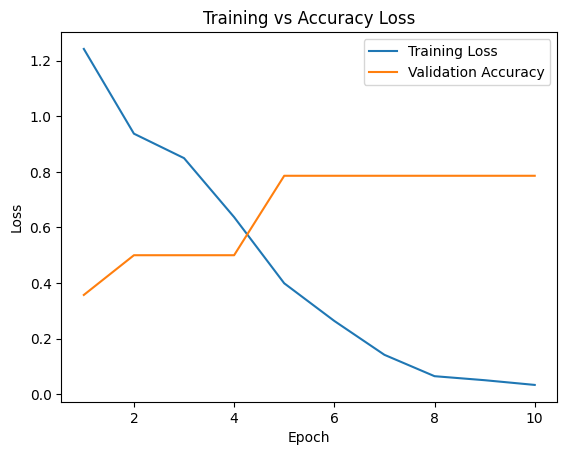

In [55]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Accuracy Loss')
plt.legend()
plt.show()

## Inference & Testing <a class="anchor" id="inference-testing"></a>

*Loading the trained model and running predictions on new commit messages.*

In [56]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import numpy as np
# Define device (cuda if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_classes = pd.read_csv('label_classes.csv', header=None).squeeze().values

le = LabelEncoder()
le.classes_ = np.array(label_classes)

# Model definition (same as training)
class DistilBertClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]  # [CLS] token equivalent
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits

# Number of labels must match training
num_labels = len(le.classes_)

# Initialize and load model to device
model = DistilBertClassifier(num_labels=num_labels)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
model.eval()

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Prediction function
def predict_commit_label(commit_message, top_k=1):
    model.eval()
    inputs = tokenizer(
        [commit_message], 
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs, dim=1)
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()
    
    labels = le.inverse_transform(top_indices)
    return list(zip(labels, top_probs))

/data1/phdiep/myenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
test_commits = [
    "Leverage getDependencies for dacapo.zip (#6337)",
    "Enable dacapo-h2 in Perf Pipeline"
]

for commit in test_commits:
    predictions = predict_commit_label(commit, top_k=3)
    print(f"Commit: {commit}")
    for label, prob in predictions:
        print(f"  Predicted: {label} (Confidence: {prob:.2f})")
    print()

Commit: Leverage getDependencies for dacapo.zip (#6337)
  Predicted: dacapo (Confidence: 0.60)
  Predicted: renaissance (Confidence: 0.27)
  Predicted: bumblebench (Confidence: 0.12)

Commit: Enable dacapo-h2 in Perf Pipeline
  Predicted: dacapo (Confidence: 0.49)
  Predicted: renaissance (Confidence: 0.38)
  Predicted: bumblebench (Confidence: 0.12)

